In [1]:
import graph_tool.all as gt

In [2]:
def ZXGraph():
    g = gt.Graph(directed=False)
    g.set_fast_edge_removal()
    g.vp.type = g.new_vertex_property('int')
    g.vp.remove = g.new_vertex_property('bool')
    #g.set_vertex_filter(g.vp.remove, inverted=True)
    return g

def vcol(t):
    if t == 0: return 'black'
    if t == 1: return 'green'
    if t == 2: return 'red'
    return 'white'

def vcols(g):
    cols = g.new_vertex_property('string')
    for v in g.vertices():
        cols[v] = vcol(g.vp.type[v])
    return cols

def match_bialg(g, interior=False):
    for e in g.edges():
        v0 = e.source()
        v1 = e.target()
        v0t = g.vp.type[v0]
        v1t = g.vp.type[v1]
        if ((v0t == 1 and v1t == 2) or (v0t == 2 and v1t == 1)):
            if (
                not interior or (
                all([g.vp.type[n] == v1t for n in v0.all_neighbors()]) and
                all([g.vp.type[n] == v0t for n in v1.all_neighbors()]))
            ):
                return [v0,v1]
    return None

def bialg(g, match, check=False):
    v0 = match[0]
    v1 = match[1]
    v0t = g.vp.type[v0]
    v1t = g.vp.type[v1]

    if check:
        if not (
            g.edge(v0,v1) and
            ((v0t == 1 and v1t == 2) or
            (v0t == 2 and v1t == 1))
        ): return False
    
    n0 = [n for n in v0.all_neighbors() if n != v1]
    n1 = [n for n in v1.all_neighbors() if n != v0]
    
    # add dummy nodes around v0, v1 as necessary.
    for i in range(len(n0)):
        if (g.vp.type[n0[i]] != v1t):
            newv = g.add_vertex()
            g.vp.type[newv] = v1t
            
            g.remove_edge(g.edge(v0,n0[i]))
            g.add_edge_list([(n0[i], newv), (newv, v0)])
            n0[i] = newv
    
    for i in range(len(n1)):
        if (g.vp.type[n1[i]] != v0t):
            newv = g.add_vertex()
            g.vp.type[newv] = v0t
            g.remove_edge(g.edge(v1,n1[i].index))
            g.add_edge_list([(v1,newv),(newv,n1[i])])
            n1[i] = newv
    
    for s in n0:
        for t in n1:
            e = g.edge(s,t)
            if e: g.remove_edge(e)
            else: g.add_edge(s, t)
    
    # delete vertices at the end so we don't mess up indices. Note indices need to be deleted from
    # last to first.
    del_list = [v0,v1] + [v for v in n0 + n1 if v.in_degree() + v.out_degree() < 2]
    for v in reversed(sorted(del_list)):
        g.remove_vertex(v, fast=True)
    return True

In [16]:
def zigzag(sz):
    g = ZXGraph()
    g.add_vertex(n=2*sz+4)
    #for i in range(1,sz+1):
    #    g.vp.type[g.vertex(2*i)] = (i%2)+1
    #    g.vp.type[g.vertex(2*i+1)] = (i%2)+1
    g.add_edge_list([(0,2),(1,3)])
    g.add_edge_list([(2*i,2*i+2) for i in range(1,sz)])
    g.add_edge_list([(2*i,2*i+3) for i in range(1,sz)])
    g.add_edge_list([(2*i+1,2*i+2) for i in range(1,sz)])
    g.add_edge_list([(2*i+1,2*i+3) for i in range(1,sz)])
    g.add_edge_list([(2*sz,2*sz+2),(2*sz+1,2*sz+3)])
    return g

In [12]:
g = ZXGraph()
%time g.add_vertex(n=10000000)
%time g.remove_vertex(9999, fast=True)

CPU times: user 234 ms, sys: 656 ms, total: 891 ms
Wall time: 888 ms
CPU times: user 15.6 ms, sys: 31.2 ms, total: 46.9 ms
Wall time: 38.1 ms


In [15]:
%time g = zigzag(100000)
%time m = match_bialg(g, interior=True)
%time bialg(g, m)

CPU times: user 9.78 s, sys: 31.2 ms, total: 9.81 s
Wall time: 9.79 s
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 597 µs
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.79 ms


True

In [249]:
g1 = zigzag(100000)
def f():
    while True:
        m = match_bialg(g1, interior=True)
        if m: bialg(g1, m)
        else: break
%time f()

CPU times: user 2min 35s, sys: 0 ns, total: 2min 35s
Wall time: 2min 35s


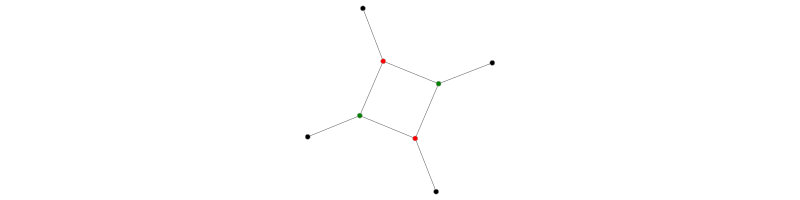

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f2e34b67b70, at 0x7f2e34b64518>

In [250]:
gt.graph_draw(g1, output_size=(800,200), vertex_size=5, vertex_fill_color=vcols(g1))

In [19]:
%time g = zigzag(10000000)

CPU times: user 36.1 s, sys: 15.3 s, total: 51.4 s
Wall time: 51.5 s
